# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [2]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]


from ema_workbench import MultiprocessingEvaluator
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
n_policies = 10

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)
    



[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


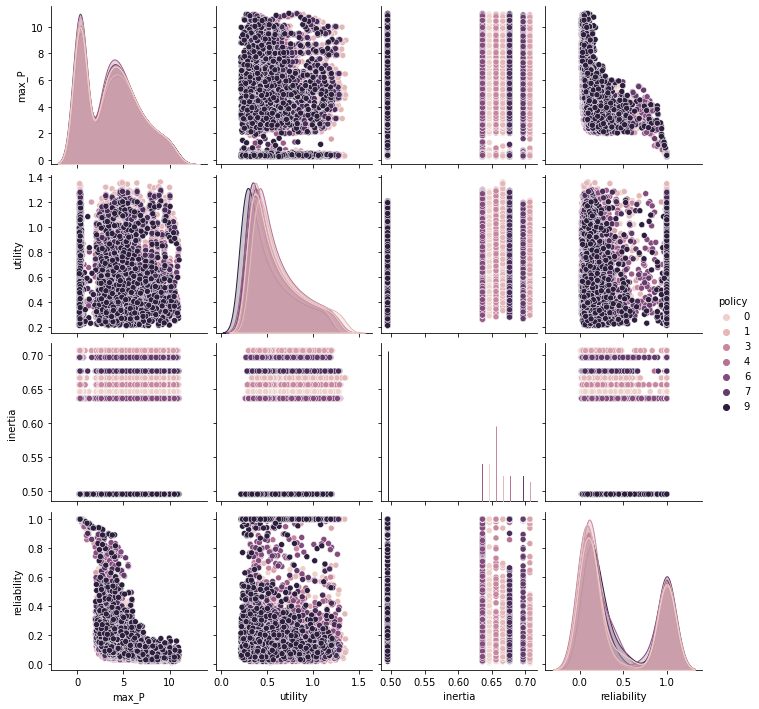

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

In [4]:
experiments.head()

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.203453,0.950296,0.029107,3.598286,0.003817,0.080332,0.033356,0.007728,0.030857,0.050097,...,0.025498,0.052169,0.002826,0.005776,0.071663,0.019023,0.079179,0,0,lakeproblem
1,0.210155,0.952232,0.040036,3.553114,0.002721,0.080332,0.033356,0.007728,0.030857,0.050097,...,0.025498,0.052169,0.002826,0.005776,0.071663,0.019023,0.079179,1,0,lakeproblem
2,0.155126,0.965573,0.017572,3.562378,0.001233,0.080332,0.033356,0.007728,0.030857,0.050097,...,0.025498,0.052169,0.002826,0.005776,0.071663,0.019023,0.079179,2,0,lakeproblem
3,0.281345,0.958469,0.038652,3.680857,0.001657,0.080332,0.033356,0.007728,0.030857,0.050097,...,0.025498,0.052169,0.002826,0.005776,0.071663,0.019023,0.079179,3,0,lakeproblem
4,0.354993,0.953264,0.031958,3.337406,0.002315,0.080332,0.033356,0.007728,0.030857,0.050097,...,0.025498,0.052169,0.002826,0.005776,0.071663,0.019023,0.079179,4,0,lakeproblem


In [5]:
from ema_workbench.analysis import feature_scoring

# filter out the levers from experiment array
experiments, outcomes = results
clean = experiments.drop([f"l{i}" for i in range(100)], axis=1)
clean.head()


,b,delta,mean,q,stdev,scenario,policy,model
0,0.203453,0.950296,0.029107,3.598286,0.003817,0,0,lakeproblem
1,0.210155,0.952232,0.040036,3.553114,0.002721,1,0,lakeproblem
2,0.155126,0.965573,0.017572,3.562378,0.001233,2,0,lakeproblem
3,0.281345,0.958469,0.038652,3.680857,0.001657,3,0,lakeproblem
4,0.354993,0.953264,0.031958,3.337406,0.002315,4,0,lakeproblem


In [6]:
#%% Feature Scoring 1D
#error value type continous
import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
x = clean
y = data['max_P']
y=y.astype('int')
fs,_= feature_scoring.get_ex_feature_scores(x, y)
fs

[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
b,0.504992
q,0.201844
mean,0.103270
delta,0.094553
stdev,0.091237
policy,0.004104


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


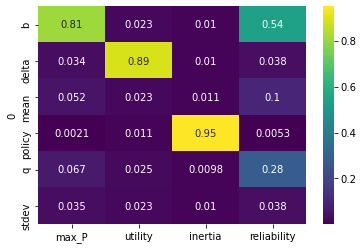

In [74]:
x = clean
y = outcomes
fsall = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fsall, cmap='viridis', annot=True)
plt.show()

In [7]:
#%% SCENARIO DISCOVERY:
#dentify 10% worst cases
reliability = data.loc[ : ,'reliability']
sortr = reliability.sort_values() #sort in ascending order (only to verify)
num_outcomes_interest=int(0.1*reliability.size) #determine 10% number out of all experiments
worst_tenpercent=reliability.nsmallest(num_outcomes_interest)# get 10% of lowest relibility experiments
threshhold_rel= max(worst_tenpercent) #determine ther threshhold

#run PRIM algortihm
from ema_workbench.analysis import prim
x=clean
interest = data['reliability'] <= threshhold_rel
prim_alg = prim.Prim(x,interest, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 1144 cases of interest
[MainProcess/INFO] mean: 0.9514563106796117, mass: 0.0515, coverage: 0.42832167832167833, density: 0.9514563106796117 restricted_dimensions: 4


coverage    0.428322
density     0.951456
id                49
mass          0.0515
mean        0.951456
res_dim            4
Name: 49, dtype: object

                 box 49                                                 
                    min              max                       qp values
b              0.100176         0.207097   [-1.0, 8.20141612228441e-138]
q              2.001393         2.752444  [-1.0, 7.544551127326738e-137]
policy  {0, 1, 2, 4, 6}  {0, 1, 2, 4, 6}    [5.21263454156704e-29, -1.0]
mean           0.012802         0.049971    [0.018922129730795736, -1.0]



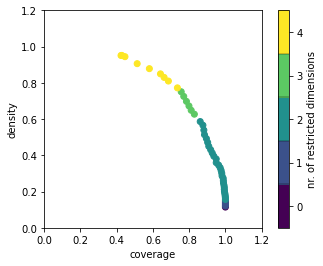

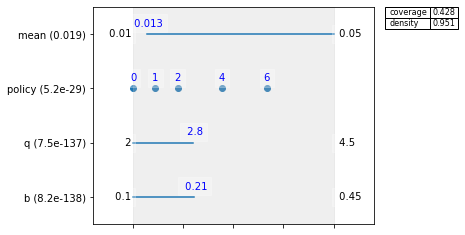

In [12]:
#Analyze prim results. Last box
box1.show_tradeoff()
box1.inspect()
box1.inspect(49,style='graph')
plt.show()


C:\Users\felo1\anaconda3\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:404: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


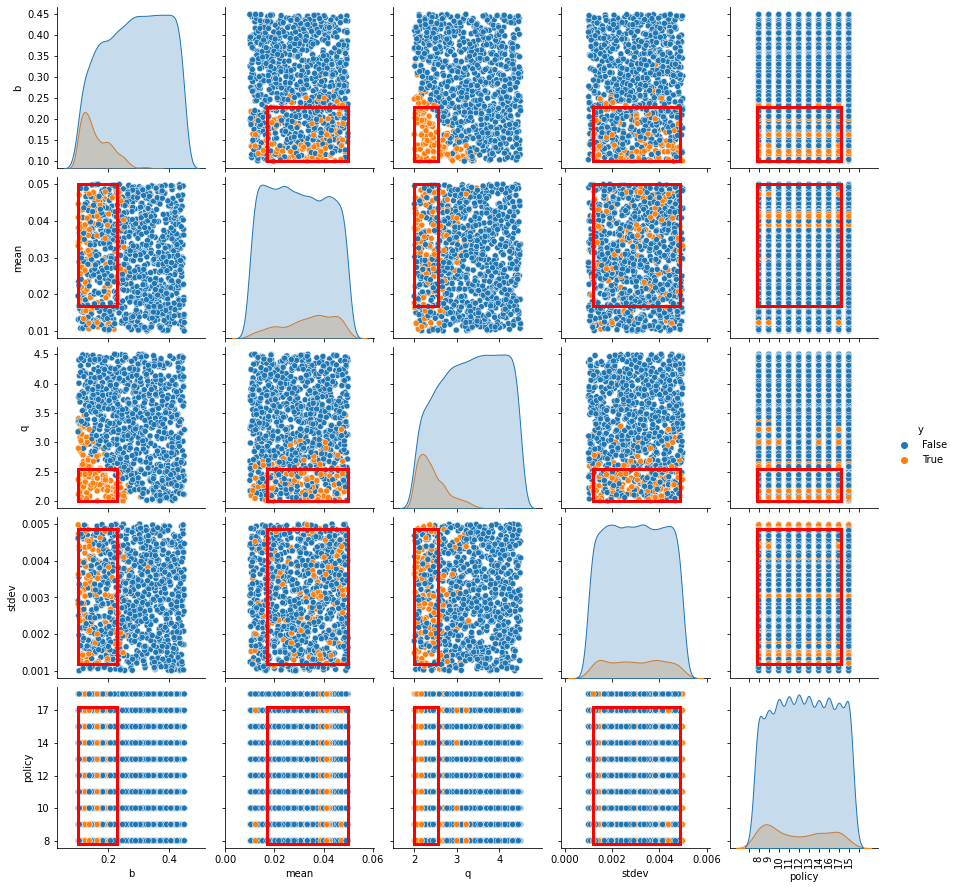

In [77]:
#scatter plot of box
box1.show_pairs_scatter()
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\felo1\anaconda3\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


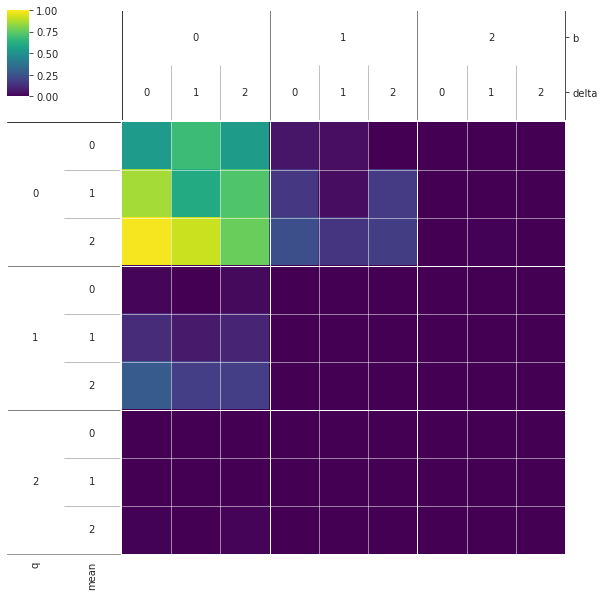

In [84]:
from ema_workbench.analysis import dimensional_stacking
dimensional_stacking.create_pivot_plot(x,interest, 2, nbins=3)
plt.show()

We can see from the dimensional stacking visual that the highest concentration of the cases with the 10% worst reliability are present if Q is low AND B is low. At the same time, the mean and stdev have additional influence, with high levels of mean and low levels of stdev having the highest concentrations.